In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.spatial.distance import cdist

sns.set_style('white')
sns.set(font_scale=2)

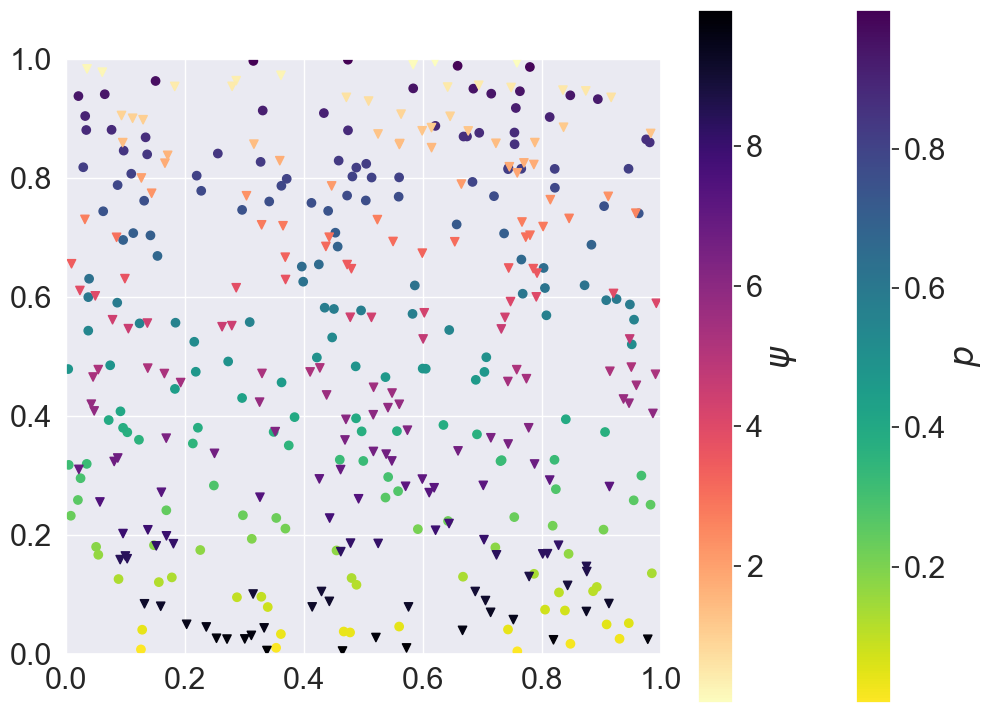

In [2]:
# Make points
l = 1
midpoint = l*0.5
maxR = l
cmapX = plt.cm.viridis_r
cmapY = plt.cm.magma_r

N_X = 200
N_Y = 200

dr = 0.05*l # dr = width of the annulus
radius_step = 0.05*l # step in the radius
PCF_radii_lower = np.arange(0, maxR, radius_step)
PCF_radii_upper = PCF_radii_lower + dr

# Both X and Y points are selected randomly
points_X = l*np.random.rand(N_Y,2)
points_Y = l*np.random.rand(N_Y,2)
labels_X = points_X[:,1]
labels_Y = 10*(l - points_Y[:,1]) # Make Y labels 10 times bigger than X labels

plt.figure(figsize=(12,9))
plt.scatter(points_X[:,0],points_X[:,1],c=labels_X,cmap=cmapX,marker='o')
plt.colorbar(label='$p$')
plt.scatter(points_Y[:,0],points_Y[:,1],c=labels_Y,cmap=cmapY,marker='v')
plt.colorbar(label='$\psi$')
plt.gca().axis('square')
plt.xlim([0,l])
plt.ylim([0,l])
plt.savefig('./S5_ComparingWeightingFunctions_points.png')

# Calculate distances to nearby cells, keeping each contribution associated with the phenotype of that point
distances = cdist(points_X, points_Y, metric='euclidean')
areas = getAnnulusAreasAroundPoints(points_X, radius_step, maxR, l)

In [3]:
# Define weighting functions
# How close is label to the target P?
def getWeights_p(P,labels):
    DeltaP = 0.1
    weights = 1-np.abs(P-labels)/DeltaP
    weights = np.maximum(weights, np.zeros(np.shape(weights)))
    return weights

# How close is label to the target Psi
def getWeights_psi(Psi,labels):
    DeltaP = 1
    weights = 1-np.abs(Psi-labels)/DeltaP
    weights = np.maximum(weights, np.zeros(np.shape(weights)))
    return weights

dP = 0.01
dPsi = 0.1
xRange = np.arange(0,1+dP,dP);
yRange = np.arange(0,10+dPsi,dPsi);

# wPCF (r, p, psi)
wPCF = np.ones(shape=(len(PCF_radii_lower),len(xRange),len(yRange)))
for indx, P in enumerate(xRange):
    # Fix a target value of P
    for indy, Psi in enumerate(yRange):
        # Fix a target value of Psi
        weights_X = getWeights_p(P,labels_X)
        weights_Y = getWeights_psi(Psi,labels_Y)
        
        totalWeight_X = sum(weights_X) # W_X
        totalWeight_Y = sum(weights_Y) # W_Y
        density_X = N_X / (l*l) # N_X / A
        density_Y = N_Y / (l*l) # N_Y / A

        wPCF_row = np.zeros(shape=(len(PCF_radii_lower)))

        # Now calculate value of wPCF at each value of r, for this P and Psi
        for annulus in range(len(PCF_radii_lower)):
            inner = PCF_radii_lower[annulus]
            outer = PCF_radii_upper[annulus]

            # Find pairwise distances within this radius
            distanceMask = np.logical_and((distances >= inner),(distances < outer))
            for i in range(N_X):
                # For each cell in X
                # Find pairwise distances within this radius of cell i
                fillIndices = np.where(distanceMask[i,:])[0]
                m_i = sum(weights_Y[fillIndices]) # m_i
                wPCF_row[annulus] = wPCF_row[annulus] + weights_X[i]*m_i*N_Y/(totalWeight_X*totalWeight_Y*density_Y*areas[i,annulus])

        wPCF[:,indx,indy] = wPCF_row

C:\Users\joshu\AppData\Local\Temp\ipykernel_30084\209789935.py:49: RuntimeWarning: invalid value encountered in double_scalars
  wPCF_row[annulus] = wPCF_row[annulus] + weights_X[i]*m_i*N_Y/(totalWeight_X*totalWeight_Y*density_Y*areas[i,annulus])


In [4]:
# Set up colormap for wPCF
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

vmin = 0
vmax = 5
one = 1/vmax

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
nCols = 1000
threshold = one*nCols

colors1 = plt.cm.Greens(np.linspace(0, 1, round(threshold)))
colors2 = plt.cm.plasma(np.linspace(0, 1, nCols - round(threshold)))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


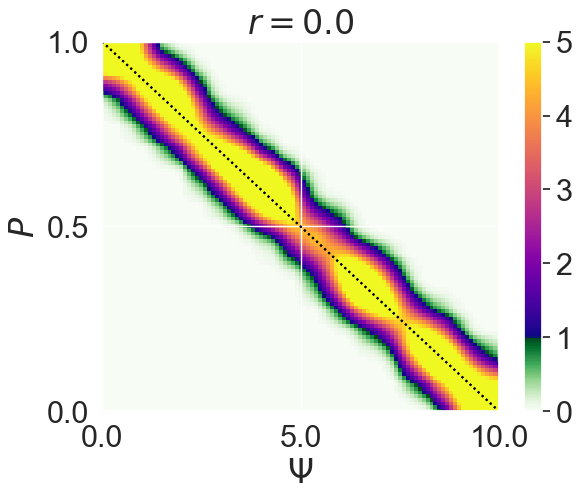

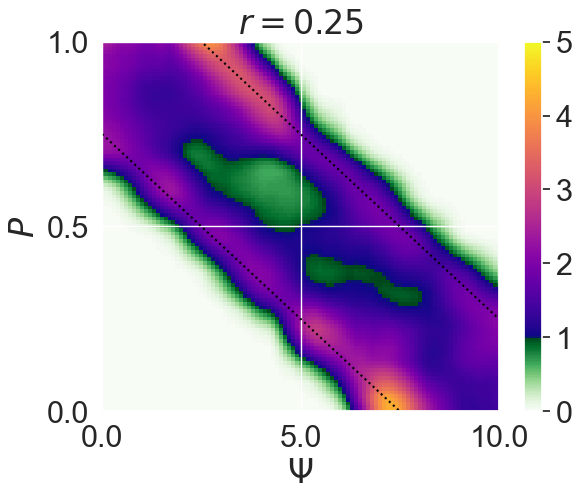

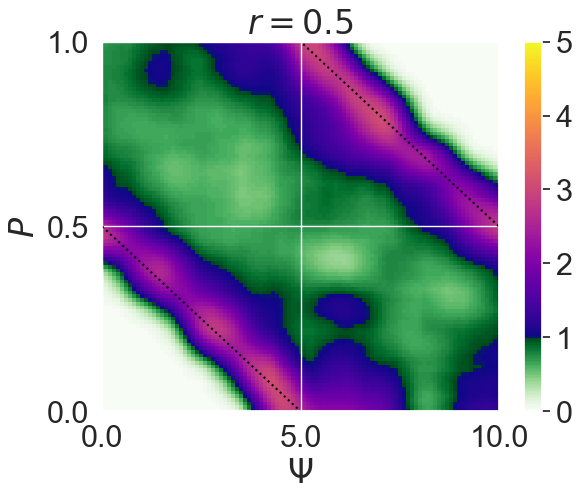

In [5]:
# The annoying factors of 100 are rescaling the array to coords corresponding with distances in point cloud
for dist in [0,5,10]:
    plt.figure()
    plt.imshow(wPCF[dist,:,:],origin='lower',cmap=cmap,vmin=vmin,vmax=vmax,aspect='auto')
    plt.plot(100*xRange,100-10*yRange+100*PCF_radii_lower[dist],color=[0,0,0],linestyle=':')
    plt.plot(100*xRange,100-10*yRange-100*PCF_radii_lower[dist],color=[0,0,0],linestyle=':')
    plt.xlabel('$\\Psi$')
    plt.ylabel('$P$')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.gca().set_xticks([0,50,100])
    plt.gca().set_xticklabels([yRange[0],yRange[50],yRange[100]])
    plt.gca().set_yticks([0,50,100])
    plt.gca().set_yticklabels([xRange[0],xRange[50],xRange[100]])
    plt.title('$r = ' + str(PCF_radii_lower[dist]) + '$')
    plt.colorbar()
    plt.savefig('./S5_ContinuousToContinuous_'+str(PCF_radii_lower[dist])+'.png')